In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision'

/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision


In [ ]:
# Load for linear algebra and data processing
import numpy as np
import pandas as pd
import tensorflow as tf

# Imports packages to view data
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
from skimage.io import imread
import cv2
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

# Import keras packages
from keras import applications
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.data_utils import Sequence
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Load the data
data_dir  = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray'
train_dir = os.path.join(data_dir,'train/')
val_dir = os.path.join(data_dir,'val/')
test_dir = os.path.join(data_dir,'test/')



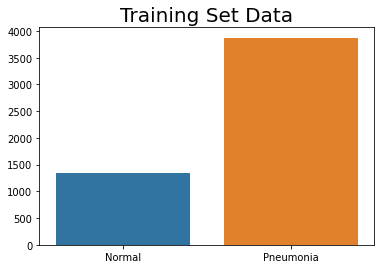

In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/'
train_data = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename)
                     for filename in os.listdir(path+'/train/NORMAL')])],
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_data).set_title('Training Set Data', fontsize=20)
plt.show()

In [ ]:
train_img = tf.io.gfile.glob('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train/*/*')
val_img = tf.io.gfile.glob('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val/*/*')

# Data before split
print(f'Before division ')
print(f'training images = {len(train_img)}')
print(f'validation images = {len(val_img)}\n')

# Merging the training and validation, to split them afterwards
total_files = train_img
total_files.extend(val_img)
print(f'Total number of images : train_img + val_img = {len(total_files)}\n')

# Spliting dataset 80:20
train_images, val_images = train_test_split(total_files, test_size = 0.2)
print(f'After division of 80:20')
print(f'training images = {len(train_images)}')
print(f'validation images = {len(val_images)}')

Before division 
training images = 5216
validation images = 16

Total number of images : train_img + val_img = 5232

After division of 80:20
training images = 4185
validation images = 1047


In [ ]:
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/negative/')
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/positive/')
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/negative/')
tf.io.gfile.makedirs('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/positive/')

In [ ]:
# Train images coping from source to destination
for img in train_images:
    path_parts = img.split('/')

    if 'PNEUMONIA' == path_parts[-2]:
        tf.io.gfile.copy(src = img, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/positive/' +  path_parts[-1])
    else:
        tf.io.gfile.copy(src = img, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/negative/' +  path_parts[-1])

# Validation images coping from source to destination
for img in val_images:
    path_parts = img.split('/')

    if 'PNEUMONIA' == path_parts[-2]:
        tf.io.gfile.copy(src = img, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/positive/' +  path_parts[-1])
    else:
        tf.io.gfile.copy(src = img, dst = '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/negative/' +  path_parts[-1])

In [ ]:
# Hyperparameters
image_size = 150
epochs = 20
batch_size = 32

# ** Data augmentation**

In [ ]:
# Data Augmentation
train_img_datagen = ImageDataGenerator(rescale = 1/255,
                                   zoom_range = 0.3,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   samplewise_center = True,
                                   rotation_range = 0.3,
                                   samplewise_std_normalization = False,
                                   featurewise_std_normalization = False,
                                   vertical_flip=True)

val_img_datagen = ImageDataGenerator(rescale = 1./255)
test_img_datagen = ImageDataGenerator(rescale = 1./255)

train_dt_gen = train_img_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

val_dt_gen = val_img_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

test_dt_gen = test_img_datagen.flow_from_directory(
     '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/test',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Assigning the weight for Regularization
total_normal_img = len([x for x in train_images if "NORMAL" in x])
total_pneumonia_img = len([x for x in train_images if "PNEUMONIA" in x])

result = np.log([total_pneumonia_img/total_normal_img])
result

weight_assign_0 = (1 / total_normal_img)*(len(train_images))/2.0
weight_assign_1 = (1 / total_pneumonia_img)*(len(train_images))/2.0

weight_assign = {0: weight_assign_0, 1: weight_assign_1}

print('Weight for class 0: {:.2f}'.format(weight_assign_0))
print('Weight for class 1: {:.2f}'.format(weight_assign_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


# **CNN model**

In [ ]:
# Regularization Callbacks
checking_point = ModelCheckpoint(filepath='best_weights.CNN', save_best_only=True)
reduce_LRO = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

In [ ]:
CNN_model = tf.keras.models.Sequential([

    # first convolution Layer
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution Layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution Layer
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution Layer
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fifth convolution Layer
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu',padding='same'),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    # Flatten the results to feed into a CNN Model
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Last?output layer, only 1 output neuron: it will contain a value from 0-1
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

In [ ]:
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                      

In [ ]:
# Compile CNN model
CNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','Recall', 'Precision'])

In [ ]:
# Fitting the CNN model
history_CNN = CNN_model.fit_generator(
    train_dt_gen,
    steps_per_epoch = train_dt_gen.samples // batch_size,
    epochs = epochs,
    validation_data = val_dt_gen,
    validation_steps = val_dt_gen.samples // batch_size,
    class_weight = weight_assign,
    callbacks = [checking_point, reduce_LRO])

<ipython-input-48-c1b3951979a5>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_CNN = CNN_model.fit_generator(


Epoch 1/20
130/130 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8141 - recall: 0.7965 - precision: 0.9433

130/130 [==============================] - 82s 613ms/step - loss: 0.4204 - accuracy: 0.8141 - recall: 0.7965 - precision: 0.9433 - val_loss: 0.5790 - val_accuracy: 0.7500 - val_recall: 1.0000 - val_precision: 0.7500 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 76s 583ms/step - loss: 0.3566 - accuracy: 0.8505 - recall: 0.8297 - precision: 0.9630 - val_loss: 0.6271 - val_accuracy: 0.7520 - val_recall: 1.0000 - val_precision: 0.7520 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 76s 589ms/step - loss: 0.3329 - accuracy: 0.8488 - recall: 0.8234 - precision: 0.9671 - val_loss: 1.3025 - val_accuracy: 0.7539 - val_recall: 1.0000 - val_precision: 0.7539 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 76s 585ms/step - loss: 0.3133 - accuracy: 0.8671 - recall: 0.8466 - precision: 0.9698 - val_loss: 0.9223 - val_accuracy: 0.7549 - val_recall: 1.0000 - val_precision: 0.7549 - lr: 0.0010
Epoch 5/20
130/130 [==============================]


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
130/130 [==============================] - 79s 605ms/step - loss: 0.3023 - accuracy: 0.8693 - recall: 0.8523 - precision: 0.9667 - val_loss: 0.4392 - val_accuracy: 0.7715 - val_recall: 0.9857 - val_precision: 0.7731 - lr: 0.0010
Epoch 6/20
130/130 [==============================] - 76s 587ms/step - loss: 0.2447 - accuracy: 0.9003 - recall: 0.8828 - precision: 0.9805 - val_loss: 0.7319 - val_accuracy: 0.7578 - val_recall: 0.9948 - val_precision: 0.7589 - lr: 3.0000e-04
Epoch 7/20
130/130 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9059 - recall: 0.8941 - precision: 0.9765
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
130/130 [==============================] - 76s 584ms/step - loss: 0.2345 - accuracy: 0.9059 - recall: 0.8941 - precision: 0.9765 - val_loss: 0.7604 - val_accuracy: 0.7910 - val_recall: 0.9871 - val_precision: 0.7893 - lr: 3.0000e-04
Epoch 8/

## **Vizualising Model performances**

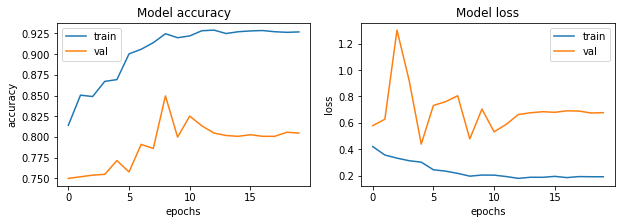

In [ ]:
fig1, axis = plt.subplots(1, 2, figsize=(10, 3))
axis = axis.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    axis[i].plot(history_CNN.history[met])
    axis[i].plot(history_CNN.history['val_' + met])
    axis[i].set_title('Model {}'.format(met))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(met)
    axis[i].legend(['train', 'val'])

**Predict and Evaluate**

In [ ]:
result_CNN_model = CNN_model.evaluate_generator(train_dt_gen, 624)
print('Loss Value for test data :', result_CNN_model[0])
print('Accuracy Value for test data :', result_CNN_model[1])
print('Recall Value for test data :', result_CNN_model[2])
print('Precision Value for test data :', result_CNN_model[3])

<ipython-input-50-ab475ca09b8e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result_CNN_model = CNN_model.evaluate_generator(train_dt_gen, 624)


Loss Value for test data : 0.16879910230636597
Accuracy Value for test data : 0.9307048916816711
Recall Value for test data : 0.9224305152893066
Precision Value for test data : 0.9827823638916016


# **Prediction Plots**

In [ ]:
check_CNN_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/best_weights.CNN')

wrong_img_prdict = [[],[]]
right_img_prdict = [[],[]]
i = 0
while i< 5 and len(wrong_img_prdict[0]) < 6:
    j = 0
    while j < 32 and len(wrong_img_prdict[0]) < 6:

        image_val = (test_dt_gen[i][0][j]).reshape(1,150,150,3)

        predict = check_CNN_model.predict(image_val)

        if int(round(predict[0][0])) != test_dt_gen[i][1][j]:
            wrong_img_prdict[0].append(image_val)
            wrong_img_prdict[1].append(int(round(predict[0][0])))

        elif len(right_img_prdict[0]) < 6:
            right_img_prdict[0].append(image_val)
            right_img_prdict[1].append(int(round(predict[0][0])))
        j += 1

    i += 1

1/1 [==============================] - 0s 20ms/step


wrong_prediction_by_model --- [1, 1, 1, 1, 1, 1]


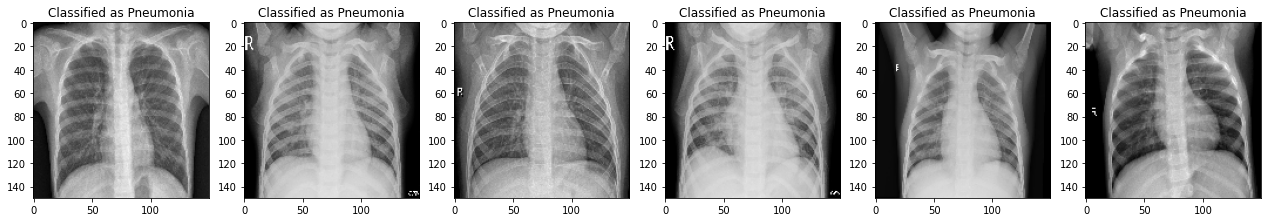

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig1, axis = plt.subplots(1,6)

i = 0
for ele in wrong_img_prdict[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(150,150,3))
    axis[i].imshow(image)
    if wrong_img_prdict[1][i] == 1:
        axis[i].set_title("Classified as Pneumonia")
    else:
        axis[i].set_title("Classified as Normal")
    i += 1

print(f'wrong_prediction_by_model --- {wrong_img_prdict[1]}')

correct_prediction_by_model --- [1, 1, 1, 1, 1, 1]


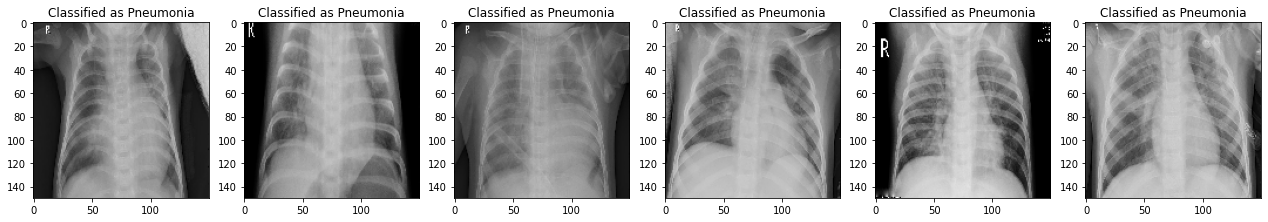

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig1, axis = plt.subplots(1,6)

i = 0
for ele in right_img_prdict[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(150,150,3))
    axis[i].imshow(image)
    if right_img_prdict[1][i] == 1:
        axis[i].set_title("Classified as Pneumonia")
    else:
        axis[i].set_title("Classified as Normal")
    i += 1

print(f'correct_prediction_by_model --- {right_img_prdict[1]}')

# **VGG-16 Model **
**VGG-16 Model: Pretrained Model**

In [ ]:
# Hyperparameters
image_size = 224
epochs = 20
batch_size = 64

train_img_dt = ImageDataGenerator(rescale = 1/255,
                                   zoom_range = 0.3,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   samplewise_center = True,
                                   rotation_range = 0.3,
                                   samplewise_std_normalization = False,
                                   featurewise_std_normalization = False,
                                   vertical_flip=True)

val_img_dt = ImageDataGenerator(rescale = 1./255)
test_img_dt = ImageDataGenerator(rescale = 1./255)

train_new_data = train_img_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

val_new_data = val_img_dt.flow_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

test_new_data = test_img_dt.flow_from_directory(
     '/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/test/',
    target_size = (image_size, image_size),
    batch_size = batch_size ,
    class_mode = 'binary'
)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
VGG_model = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3),
                                       include_top=False,
                                       weights='imagenet')
VGG_model.trainable = False

# Added extra layers which we found to be
VGG = tf.keras.Sequential([
        VGG_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

# Compile our model
VGG.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', 'Recall', 'Precision'])
VGG.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                       

In [ ]:
print(len(VGG_model.layers))

19


In [ ]:
# Callbacks for Regularization
checking_point = ModelCheckpoint(filepath='best_weights.VGG',
                             save_best_only=True)
reduce_LRO = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=2,
                              mode='max')

In [ ]:
history_VGG = VGG.fit_generator(
    train_new_data,
    steps_per_epoch = train_new_data.samples // batch_size,
    epochs = epochs,
    validation_data = val_new_data,
    validation_steps = val_new_data.samples // batch_size,
    class_weight = weight_assign,
    callbacks= [checking_point, reduce_LRO])

<ipython-input-25-5c0ce5d708b5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG = VGG.fit_generator(


Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.7959 - recall: 0.7919 - precision: 0.9210

65/65 [==============================] - 109s 2s/step - loss: 0.6228 - accuracy: 0.7959 - recall: 0.7919 - precision: 0.9210 - val_loss: 0.3880 - val_accuracy: 0.8271 - val_recall: 0.7746 - val_precision: 0.9950 - lr: 0.0010
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9051 - recall: 0.8962 - precision: 0.9733

65/65 [==============================] - 103s 2s/step - loss: 0.2198 - accuracy: 0.9051 - recall: 0.8962 - precision: 0.9733 - val_loss: 0.2340 - val_accuracy: 0.9131 - val_recall: 0.8899 - val_precision: 0.9942 - lr: 0.0010
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9109 - recall: 0.9028 - precision: 0.9753
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
65/65 [==============================] - 101s 2s/step - loss: 0.2196 - accuracy: 0.9109 - recall: 0.9028 - precision: 0.9753 - val_loss: 0.3003 - val_accuracy: 0.8867 - val_recall: 0.8549 - val_precision: 0.9940 - lr: 0.0010
Epoch 4/20
65/65 [==============================] - 103s 2s/step - loss: 0.1800 - accuracy: 0.9282 - recall: 0.9255 - precision: 0.9761 - val_loss: 0.2581 - val_accuracy: 0.9072 - val_recall: 0.8823 - val_precision: 0.9942 - lr: 3.0000e-04
Epoch 5/20
65/65 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9328 - recall:


Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
65/65 [==============================] - 105s 2s/step - loss: 0.1642 - accuracy: 0.9328 - recall: 0.9266 - precision: 0.9816 - val_loss: 0.2312 - val_accuracy: 0.9092 - val_recall: 0.8844 - val_precision: 0.9942 - lr: 3.0000e-04
Epoch 6/20
65/65 [==============================] - 103s 2s/step - loss: 0.1529 - accuracy: 0.9398 - recall: 0.9380 - precision: 0.9798 - val_loss: 0.2555 - val_accuracy: 0.9092 - val_recall: 0.8846 - val_precision: 0.9942 - lr: 9.0000e-05
Epoch 7/20
65/65 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9415 - recall: 0.9353 - precision: 0.9848
Epoch 7: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
65/65 [==============================] - 101s 2s/step - loss: 0.1493 - accuracy: 0.9415 - recall: 0.9353 - precision: 0.9848 - val_loss: 0.2999 - val_accuracy: 0.8916 - val_recall: 0.8616 - val_precision: 0.9940 - lr: 9.0000e-05
Epoch 8/20
65/65 [

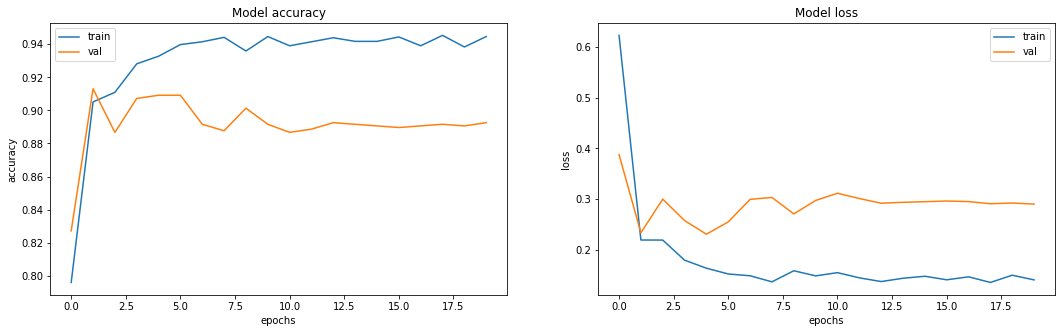

In [ ]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history_VGG.history[element])
    axis[i].plot(history_VGG.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

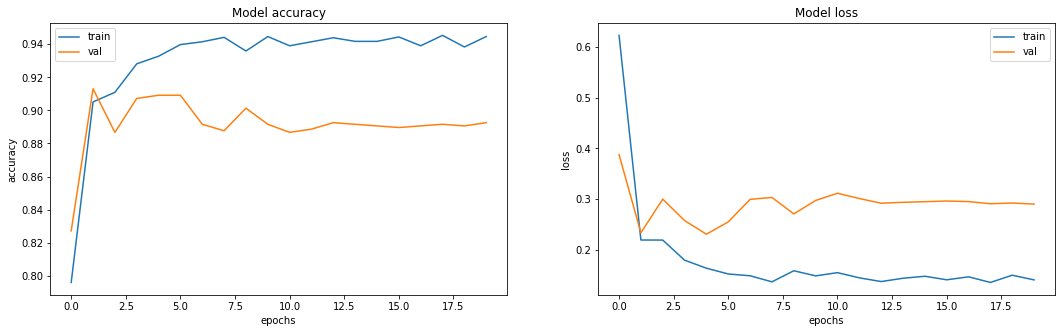

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history_VGG.history[element])
    axis[i].plot(history_VGG.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [ ]:
result_VGG = VGG.evaluate_generator(test_new_data, 624)
print('Loss value for test data :', result_VGG[0])
print('Accuracy value for test data :', result_VGG[1])
print('Recall value for test data :', result_VGG[2])
print('Precision value for test data :', result_VGG[3])

<ipython-input-28-fd8360737c29>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result_VGG = VGG.evaluate_generator(test_new_data, 624)


Loss value for test data : 0.23657965660095215
Accuracy value for test data : 0.9070512652397156
Recall value for test data : 0.9128205180168152
Precision value for test data : 0.9368420839309692


In [ ]:
check_VGG16_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/best_weights.VGG')

wrong_img_prdict = [[],[]]
right_img_prdict = [[],[]]
i = 0
while i< 5 and len(wrong_img_prdict[0]) < 6:
    j = 0
    while j < 32 and len(wrong_img_prdict[0]) < 6:

        image_val = (test_new_data[i][0][j]).reshape(1,224,224,3)

        predict = check_VGG16_model.predict(image_val)

        if int(round(predict[0][0])) != test_new_data[i][1][j]:
            wrong_img_prdict[0].append(image_val)
            wrong_img_prdict[1].append(int(round(predict[0][0])))

        elif len(right_img_prdict[0]) < 6:
            right_img_prdict[0].append(image_val)
            right_img_prdict[1].append(int(round(predict[0][0])))
        j += 1

    i += 1

1/1 [==============================] - 0s 16ms/step


wrong_prediction_by_model --- [1, 0, 0, 1, 0, 1]


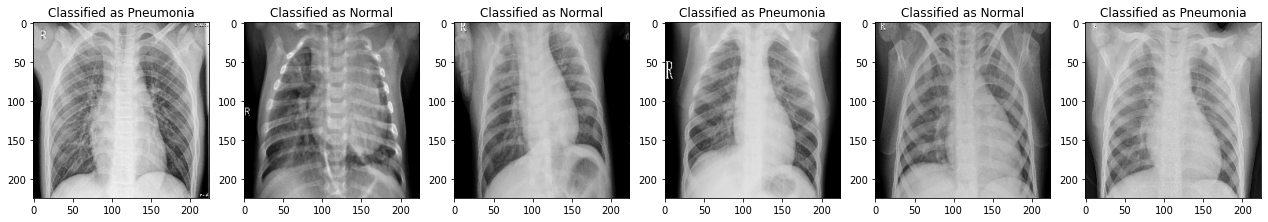

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig1, axis = plt.subplots(1,6)

i = 0
for ele in wrong_img_prdict[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    axis[i].imshow(image)
    if wrong_img_prdict[1][i] == 1:
        axis[i].set_title("Classified as Pneumonia")
    else:
        axis[i].set_title("Classified as Normal")
    i += 1

print(f'wrong_prediction_by_model --- {wrong_img_prdict[1]}')

Right_prediction_by_model --- [1, 0, 0, 1, 1, 1]


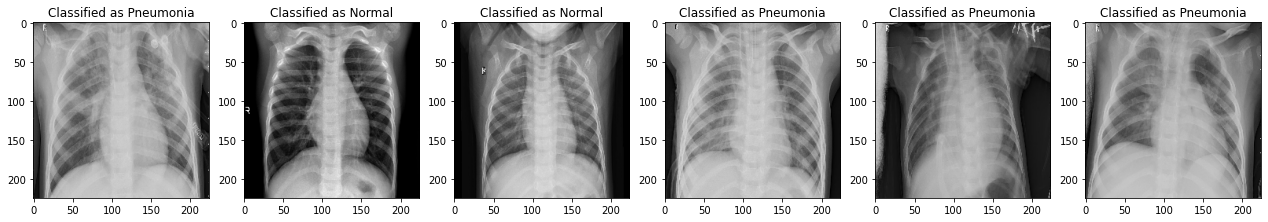

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig1, axis = plt.subplots(1,6)

i = 0
for ele in right_img_prdict[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    axis[i].imshow(image)
    if right_img_prdict[1][i] == 1:
        axis[i].set_title("Classified as Pneumonia")
    else:
        axis[i].set_title("Classified as Normal")
    i += 1

print(f'Right_prediction_by_model --- {right_img_prdict[1]}')

# **ResNet-50**

In [ ]:
# Import ResNet-50 from tensorflow keras
from tensorflow.keras.applications.resnet50 import ResNet50

base_resnet = ResNet50(input_shape=(image_size, image_size, 3),
                                                     include_top=False,
                                                     weights='imagenet')
for layers in base_resnet.layers:
    layers.trainable = False

# Add extra layers which we found to be
ResNet = tf.keras.Sequential([
        base_resnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

# Compile model
ResNet.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy', 'Recall', 'Precision'])

# ResNet.summary()

ImportError: ignored

In [ ]:
checking_point = ModelCheckpoint(filepath='best_weights.ResNet',
                             save_best_only=True)
reduce_LRO = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=2,
                              mode='max')

In [ ]:
print(len(base_resnet.layers))

In [ ]:
history_ResNet = ResNet.fit_generator(
    train_new_data,
    steps_per_epoch = train_new_data.samples // batch_size,
    epochs = epochs,
    validation_data = val_new_data,
    validation_steps = val_new_data.samples // batch_size,
    class_weight = weight_assign,
    callbacks= [checking_point, reduce_LRO])

In [ ]:
result_ResNet = ResNet.evaluate_generator(test_new_data, 624)
print('Loss value for test data :', result_ResNet[0])
print('Accuracy value for test data :', result_ResNet[1])
print('Recall value for test data :', result_ResNet[2])
print('Precision value for test data :', result_ResNet[3])

In [ ]:
check_ResNet50_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/best_weights.ResNet')

wrong_img_prdict = [[],[]]
right_img_prdict = [[],[]]
i = 0
while i< 5 and len(wrong_img_prdict[0]) < 6:
    j = 0
    while j < 32 and len(wrong_img_prdict[0]) < 6:

        image_val = (test_new_data[i][0][j]).reshape(1,224,224,3)

        predict = check_ResNet50_model.predict(image_val)

        if int(round(predict[0][0])) != test_new_data[i][1][j]:
            wrong_img_prdict[0].append(image_val)
            wrong_img_prdict[1].append(int(round(predict[0][0])))

        elif len(right_img_prdict[0]) < 6:
            right_img_prdict[0].append(image_val)
            right_img_prdict[1].append(int(round(predict[0][0])))
        j += 1

    i += 1

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig1, axis = plt.subplots(1,6)

i = 0
for ele in wrong_img_prdict[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    axis[i].imshow(image)
    if wrong_img_prdict[1][i] == 1:
        axis[i].set_title("Classified as Pneumonia")
    else:
        axis[i].set_title("Classified as Normal")
    i += 1

print(f'wrong_prediction_by_model --- {wrong_img_prdict[1]}')


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig1, axis = plt.subplots(1,6)

i = 0
for ele in right_img_prdict[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(224,224,3))
    axis[i].imshow(image)
    if right_img_prdict[1][i] == 1:
        axis[i].set_title("Classified as Pneumonia")
    else:
        axis[i].set_title("Classified as Normal")
    i += 1

print(f'right_prediction_by_model --- {right_img_prdict[1]}')

In [ ]:
# # Deleting all the directories created in the below cell as it is only created to divide the dataset.

# tf.io.gfile.rmtree('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/val_dataset/')
# tf.io.gfile.rmtree('/content/gdrive/MyDrive/Colab Notebooks/Project_computer_Vision/chest_xray/train_dataset/')